# Part B: Reinforcement Learning using DQN

# Table of Contents
- [Introduction](#What-is-Reinforcement-Learning-(RL)?)
- [Background Research - Understanding the Assignement](#Background-Research)
- [Modelling](#Modelling)
- [Model Improvement 1](#Model-Improvement-1---Introducing-Exploration-Decay)
- [Model Improvement 2](#Model-Improvement-2---Speed-up-learning)
- [Final Model](#Final-Model)
- [Conclusion](#Part-B-Conclusion)

# What is Reinforcement Learning (RL)?

Reinforcement Learning (RL) is a type of machine learning where an agent learns to make decisions by interacting with an environment. At each step, the agent:

- Observes the current **state**.
- Chooses an **action**.
- Receives a **reward**.
- Transitions to the next **state**.

The goal is to **maximize cumulative rewards** over time by learning the best actions to take in each state.

Unlike supervised learning, RL does **not require labeled data**. Instead, it learns from experience — through **trial and error**.

---

## Types of Reinforcement Learning

| Category         | Subtype              | Description |
|------------------|----------------------|-------------|
| **Learning Method** | Model-Free            | Learns directly from interactions without modeling the environment (e.g. Q-Learning, DQN). |
|                  | Model-Based          | Builds a model of the environment to plan ahead. |
| **Optimization** | Value-Based          | Learns value functions to derive policies (e.g. DQN). |
|                  | Policy-Based         | Learns the policy directly (e.g. PPO, REINFORCE). |
|                  | Actor-Critic         | Combines value-based and policy-based approaches (e.g. A2C, DDPG). |
| **Action Space** | Discrete             | Finite number of possible actions (e.g. CartPole). |
|                  | Continuous           | Infinite range of actions (e.g. Pendulum). |

---

## Real-World Applications of RL

Reinforcement Learning is widely used in:

- **Robotics** – For motion control and decision making in dynamic environments.
- **Games** – RL agents have mastered games like Chess, Go, and Atari.
- **Recommendation Systems** – Personalizing user feeds (e.g. YouTube, Netflix).
- **Autonomous Driving** – Learning driving behaviors in simulated or real-world settings.
- **Finance** – Algorithmic trading strategies and portfolio optimization.

## Imports

In [1]:
import gym
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Lambda
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
import time
import os

## CPU Usage

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Background Research 

## Problem Statement

In this task, we are required to apply **Reinforcement Learning (RL)** to solve the classic control problem of balancing a pendulum. Specifically, the assignment instructs us to:

- Use the `Pendulum-v0` environment from **OpenAI Gym**.
- Implement a **Deep Q-Network (DQN)** solution.
- Handle the **continuous action space** by applying **discretization**.

The objective is to train an agent that learns to keep the pendulum upright by applying appropriate torques at each timestep.

---

## What is Deep Q-Network (DQN)?

DQN is a model-free, value-based reinforcement learning algorithm. It approximates the **Q-value function** using a neural network to evaluate the **expected future reward** of taking an action in a given state.

The Q-value update rule in Q-Learning is given by:

$$
Q_{\text{new}} = (1 - \alpha) Q_{\text{old}} + \alpha \left( R + \gamma \cdot \max_{a'} Q(S_{\text{future}}, a') \right)
$$

This formula blends the old estimate ($Q_{\text{old}}$) with a new estimate based on the **immediate reward** $R$ and the **maximum predicted Q-value** of the next state.  
Here, $\alpha$ is the learning rate (how much to trust the new info), and $\gamma$ is the discount factor (how much to value future rewards).

In DQN, this Q-function is approximated using a deep neural network. Since Pendulum has a **continuous action space**, we need to discretize it into a finite set of torque values to make DQN applicable.

---

## What is OpenAI Gym?

[OpenAI Gym](https://www.gymlibrary.dev/) is a standard toolkit for developing and testing reinforcement learning algorithms. It provides:

- A simple interface to interact with environments (`env.reset()`, `env.step()`, etc.)
- A large suite of benchmark problems including classic control, Atari games, and robotics.

---

## About the Pendulum Environment (`Pendulum-v0`)

The `Pendulum-v0` environment simulates a simple pendulum with the goal of keeping it upright (angle = 0) using minimal energy. It is designed as a continuous control task.

--- 

## Why Use DQN for This Problem?

To solve the pendulum balancing task, we use the **Deep Q-Network (DQN)** framework — a model-free, value-based reinforcement learning algorithm.

DQN is suitable because:

- It estimates the **Q-values** (expected future rewards) for each possible action given a state.
- It uses a **neural network** to generalize across the continuous state space of the pendulum (e.g. angle and velocity).
- While DQN is designed for **discrete action spaces**, we discretize the pendulum’s torque range into fixed values to make it compatible.

This allows DQN to treat the torque control task as a **classification problem**, where each discrete action index corresponds to a specific torque level.

By learning through trial and error using the Q-learning update rule, the agent improves its policy to apply the right torque at each timestep, keeping the pendulum upright with minimal energy.

### Why Only Use Standard DQN (and Not Double or Dueling DQN)

For this project, only the **standard DQN** was used to:

- **Establish a strong baseline**: Before implementing more complex variants like Double or Dueling DQN, it's important to evaluate the effectiveness of the original algorithm.
- **Focus on tuning and understanding core elements** such as epsilon decay, replay memory, and neural architecture, without adding complexity from multiple extensions.

---

### State Space: Observation Breakdown

The observation space in `Pendulum-v0` consists of 3 continuous values:

- $\cos(\theta)$ – cosine of the pendulum angle
- $\sin(\theta)$ – sine of the pendulum angle
- $\dot{\theta}$ – angular velocity (i.e., the rate at which the pendulum is swinging)

This 3-dimensional state vector is used by the agent to determine its next action.

In [13]:
env = gym.make("Pendulum-v0")

# Inspect state space details
state = env.reset()
print("Initial Observation (state):", state)

print("\nObservation Space:")
print("Type:", type(env.observation_space))
print("Shape:", env.observation_space.shape)
print("Range:", env.observation_space.low, "to", env.observation_space.high)

Initial Observation (state): [-0.97743886 -0.21121856 -0.1781523 ]

Observation Space:
Type: <class 'gym.spaces.box.Box'>
Shape: (3,)
Range: [-1. -1. -8.] to [1. 1. 8.]


#### Interpretation:
- $\cos(\theta) = -0.977$: The pendulum is pointing mostly downward.
- $\sin(\theta) = -0.211$: Slight clockwise tilt.
- $\dot{\theta} = -0.178$: Rotating slowly clockwise.

Each element of the state vector has a fixed range defined by the environment:

| State Component        | Description                 | Min Value | Max Value |
|------------------------|-----------------------------|-----------|-----------|
| $\cos(\theta)$         | Cosine of the pendulum angle | -1        | 1         |
| $\sin(\theta)$         | Sine of the pendulum angle   | -1        | 1         |
| $\dot{\theta}$         | Angular velocity             | -8        | 8         |

These bounds help in understanding the space in which the agent operates. The values are normalized and continuous.

---


### Action Space: Torque Control

The `Pendulum-v0` environment uses a **continuous action space** where the agent must decide how much torque (force) to apply to the base of the pendulum at each step.

- The action is a single **real-valued number**.
- This torque directly affects the pendulum’s angular velocity and position.
- The valid torque range is from **-2.0 to 2.0**.

Since **DQN only supports discrete actions**, we will later **discretize this range** into a fixed set of torque values (e.g. 11 or 21 levels).

In [15]:
# Inspect action space
print("Action Space:")
print("Type:", type(env.action_space))
print("Shape:", env.action_space.shape)
print("Range:", env.action_space.low, "to", env.action_space.high)

# Sample a random action
sample_action = env.action_space.sample()
print("\nSample Action:", sample_action)

Action Space:
Type: <class 'gym.spaces.box.Box'>
Shape: (1,)
Range: [-2.] to [2.]

Sample Action: [-1.1020722]


#### Interpretation:

| Action Component | Description                      | Min Value | Max Value |
|------------------|----------------------------------|-----------|-----------|
| Torque           | Force applied to rotate pendulum | -2.0      | 2.0       |

- The action is a **1D continuous Box**, meaning a single float value.
- Sampled action `-1.10` → The agent is applying a **moderate clockwise torque**.
- Values near **-2.0** apply strong clockwise force, and values near **2.0** apply strong counterclockwise force.

This torque becomes the **output** of the agent’s policy, and we’ll discretize this space into fixed steps so DQN can work with it.

---

### Reward Function: What the Agent Tries to Maximize

In reinforcement learning, the **reward function** defines the goal. The agent learns by maximizing rewards over time.

In the `Pendulum-v0` environment, the goal is to keep the pendulum upright (angle = 0), steady (low angular velocity), and with minimal effort (low torque).

#### Reward Function Formula

At each step, the agent receives a **negative reward** (i.e., penalty):

$$
r = -\left(\theta^2 + 0.1 \cdot \dot{\theta}^2 + 0.001 \cdot \text{torque}^2\right)
$$

Where:
- $\theta$ = angle from upright position (in radians)
- $\dot{\theta}$ = angular velocity
- `torque` = action applied by the agent

> The smaller the values of angle, angular velocity, and torque, the closer the reward is to 0 (which is best).

This function penalizes:
- Large swings (angle error)
- Fast spinning (angular velocity)
- Large torques (over-effort)

The **best possible reward** per step is **close to 0**, and **worst** can go below **-16**.

In [19]:
# Example variables
theta = np.pi / 4           # 45 degrees from upright
theta_dot = 2.0             # moderate spin
torque = 1.5                # moderate torque

# Calculate reward
reward = -(theta**2 + 0.1 * theta_dot**2 + 0.001 * torque**2)
print("Reward Example:", reward)

Reward Example: -1.019100275068085


#### Interpretation

- The reward is **always negative**, so the agent learns to **maximize it** (get as close to 0 as possible).
- In this example:
  - $\theta = \frac{\pi}{4}$ → Moderate tilt → contributes ~0.62 penalty
  - $\dot{\theta} = 2.0$ → Moderate spin → contributes ~0.4 penalty
  - Torque = 1.5 → Low effort → contributes ~0.003 penalty

Overall:
- The agent is **slightly off-balance**, **spinning**, and using **some effort**, resulting in a moderate penalty of **-1.0191**
- Over 200 steps, a similar behavior would lead to total episode reward ≈ **-200**

In summary, the agent is trained to:
- Keep $\theta \approx 0$ → Stay upright
- Keep $\dot{\theta} \approx 0$ → Avoid swinging
- Apply minimal torque → Conserve effort

The **closer the reward is to 0**, the **better the performance**.

In [17]:
print("Max Episode Steps:", env._max_episode_steps)

Max Episode Steps: 200


> Note: The reward is given **per step**, but what you usually see during training is the **total reward over an entire episode** (sum of 200 steps).

- Per-step reward typically ranges between **~0 (best)** and **~ -16 (worst)**
- Total episode reward can go down to **-2000 to -3000** if the agent fails to control the pendulum

That’s why early-stage DQN agents often show total rewards like **-500**, **-1000**, or worse.

---

### Action Discretization for DQN

The `Pendulum-v0` environment has a **continuous action space**, where the agent must choose a real-valued torque between **-2.0 and 2.0**.

However, the **Deep Q-Network (DQN)** algorithm only works with **discrete** action spaces — it needs a fixed number of actions to choose from.

### Solution: Discretization

We solve this by converting the continuous torque range into a fixed set of **evenly spaced discrete values** (e.g. 11 values):

- Instead of selecting from all values in [-2, 2], the agent chooses from:
  $$
  \{-2.0, -1.6, -1.2, \dots, 1.6, 2.0\}
  $$

This allows DQN to output a discrete action index (e.g. 0 to 10), which we then **map back to a real torque value**.

Discretization bridges the gap between continuous control tasks and discrete-action RL algorithms like DQN.

In [23]:
# Discretize the action space for DQN
N_ACTIONS = 11  

def PendulumActionConverter(A, NActions=N_ACTIONS):
    return (A / (NActions - 1) - 0.5) * 4

def PendulumInverseActionConverter(A, NActions=N_ACTIONS):
    return round((A + 2) * (NActions - 1) / 4)

# Test it
discrete_actions = [PendulumActionConverter(i) for i in range(N_ACTIONS)]
print("Discretized torque values:", discrete_actions)

Discretized torque values: [-2.0, -1.6, -1.2, -0.8, -0.3999999999999999, 0.0, 0.3999999999999999, 0.7999999999999998, 1.2000000000000002, 1.6, 2.0]


We discretize the continuous torque range [-2.0, 2.0] into `N_ACTIONS = 11` evenly spaced values to make the environment compatible with DQN, which only supports discrete action spaces.

- Using 11 actions provides a symmetrical spread with a midpoint of **0.0 torque**.
- This is a good starting point for training and can be **tuned later** (e.g. 21 or 51 actions) for finer control or better performance.

#### Choosing N_ACTIONS: Trade-offs

| N_ACTIONS       | Description          | Pros                    | Cons                     |
|------------------|----------------------|--------------------------|--------------------------|
| 5–11             | Coarse control        | Fast training, stable    | Less precise movement    |
| 21–51+           | Fine-grained control  | Smoother torque control  | Slower, harder to converge |

Start small, then increase if better control is needed.

#### Function Breakdown:
- `PendulumActionConverter(index)`  
  Converts a **discrete index** (0 to 10) into its corresponding **continuous torque value**.

- `PendulumInverseActionConverter(torque)`  
  Converts a **real torque** back into the **closest discrete index**, useful for debugging or logging.

This approach enables DQN to interact with a continuous-action environment by treating torque decisions as a classification problem over fixed torque levels.

---

# Modelling

## DQN Setup

### Hyperparameter Explanations

- `ENV_NAME = 'Pendulum-v0'`  
  → We're using the classic control environment where the goal is to balance a pendulum using torque. It's a standard benchmark for continuous control tasks.

- `INPUT_SHAPE = 3`  
  → The state space includes `[cos(θ), sin(θ), θ̇]`. These 3 values fully describe the pendulum’s position and movement.

- `GAMMA = 0.99`  
  → A high discount factor ensures the agent values long-term rewards, which is important for continuous balancing tasks. This is a common choice in control problems.

- `LEARNING_RATE = 0.0001`  
  → A conservative value that helps stabilize learning in the early stages. It's good for baselines to prevent overshooting or divergence.

- `REPLAY_MEMORY_SIZE = 20000`  
  → Large enough to capture a variety of experiences for training, but still small enough to fit comfortably in memory for fast training. Ideal for low-dimensional tasks like Pendulum.

- `MIN_REPLAY_MEMORY = 1000`  
  → Ensures the replay buffer has enough variety before training starts. Prevents training on too little or too biased data.

- `BATCH_SIZE = 64`  
  → A standard mini-batch size that balances training speed and stability. Works well for MSE loss and small networks.

- `UPDATE_TARGET_EVERY = 1`  
  → Updates the target network after every episode. This is fine for baseline runs to speed up early learning, though it may cause more fluctuation.

- `EPISODES = 100`  
  → A short training run, enough to check if the agent starts learning trends. Useful for debugging and testing model stability.

- `SHOW_EVERY = 10`  
  → Renders the environment every 10 episodes to visually inspect behavior. Keeps output readable while still showing progress.

- `epsilon = 1.0`  
  → Full exploration. This forces the agent to act randomly, helping it populate the replay buffer with a diverse range of actions. It's common to fix epsilon at 1.0 for initial baselines before tuning.

---

### Seeding Explanation

- Setting a fixed `seed` across Python, NumPy, and TensorFlow ensures that training runs are **reproducible** and consistent, useful for testing baselines and debugging.  
- The value `42` is a widely used convention in programming.


In [26]:
# ==== Hyperparameters ====
ENV_NAME = 'Pendulum-v0'
INPUT_SHAPE = 3
GAMMA = 0.99
LEARNING_RATE = 0.0001
REPLAY_MEMORY_SIZE = 20000
MIN_REPLAY_MEMORY = 1000
BATCH_SIZE = 64
UPDATE_TARGET_EVERY = 1
EPISODES = 100
SHOW_EVERY = 10
epsilon = 1.0  # Fixed

In [27]:
# ==== Seeding ====
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

## DQN Class: Breakdown

### `__init__(self)`
Initializes the DQN agent:
- Builds two models: `Main` (for prediction) and `Target` (for stable Q-targets)
- Sets up the Adam optimizer and a replay memory buffer
- Initializes a counter to control how often the target network is updated

---

### `create_model(self, name)`
Builds a simple feedforward neural network:
- Input layer: accepts a state of shape `(INPUT_SHAPE,)`
- Hidden layers: 64 units → 32 units, both using ReLU activation
- Output layer: `N_ACTIONS` units with linear activation, representing predicted Q-values for each discrete action

---

### `update_replay_memory(self, experience)`
Adds a new experience tuple (state, action, reward, next_state, done) to the replay memory buffer.

---

### `train(self, end_of_episode)`
Performs one training step if enough data is in the replay buffer:
- Randomly samples a batch of experiences
- Computes updated Q-values using the Bellman equation:
  - If `done`, target = reward
  - Else, target = reward + γ * max future Q-value
- Trains the `Main` model using these targets
- Updates the `Target` model every few episodes based on `UPDATE_TARGET_EVERY`

---

### `gradient_tape_fit(self, X, Y)`
Applies gradient descent using TensorFlow:
- Calculates predictions and mean squared error loss
- Computes gradients and applies them using the Adam optimizer
- Decorated with `@tf.function` for better performance

---

This class allows the agent to learn Q-values from past experiences and improve its decision-making over time using deep learning.

In [28]:
# ==== DQN Model ====
class DQN:
    def __init__(self):
        self.Main = self.create_model('Main')
        self.Target = self.create_model('Target')
        self.Target.set_weights(self.Main.get_weights())
        self.Optimiser = Adam(learning_rate=LEARNING_RATE)
        self.ReplayMemory = deque(maxlen=REPLAY_MEMORY_SIZE)
        self.TargetUpdateCounter = 0

    def create_model(self, name):
        inputs = Input(shape=(INPUT_SHAPE,), name='Input')
        x = Dense(64, activation='relu')(inputs)
        x = Dense(32, activation='relu')(x)
        outputs = Dense(N_ACTIONS, activation='linear')(x)
        return Model(inputs, outputs, name=name)

    def update_replay_memory(self, experience):
        self.ReplayMemory.append(experience)

    def train(self, end_of_episode):
        if len(self.ReplayMemory) < MIN_REPLAY_MEMORY:
            print(f"DID NOT TRAIN..., replay memory = {len(self.ReplayMemory)}")
            return

        batch = random.sample(self.ReplayMemory, BATCH_SIZE)
        states = np.array([exp[0] for exp in batch])
        next_states = np.array([exp[3] for exp in batch])
        q_values = np.array(self.Main(states))
        future_qs = self.Target(next_states)

        X, Y = [], []
        for i, (state, action, reward, next_state, done) in enumerate(batch):
            new_q = reward if done else reward + GAMMA * np.max(future_qs[i])
            q_values[i][action] = new_q
            X.append(state)
            Y.append(q_values[i])

        self.gradient_tape_fit(np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32))

        if end_of_episode:
            self.TargetUpdateCounter += 1
            if self.TargetUpdateCounter >= UPDATE_TARGET_EVERY:
                self.Target.set_weights(self.Main.get_weights())
                self.TargetUpdateCounter = 0

    @tf.function
    def gradient_tape_fit(self, X, Y):
        with tf.GradientTape() as tape:
            predictions = self.Main(X, training=True)
            loss = tf.reduce_mean(tf.square(Y - predictions))
        grads = tape.gradient(loss, self.Main.trainable_variables)
        self.Optimiser.apply_gradients(zip(grads, self.Main.trainable_variables))

### `one_episode()` Function Explanation

This function runs one full episode of interaction between the DQN agent and the environment.

#### Key Steps:

1. **Environment setup**  
   - Creates a new instance of the `Pendulum-v0` environment
   - Sets the environment seed for reproducibility
   - Resets the environment to get the initial state

2. **Episode loop (until `done`)**
   - Gets Q-values from the `Main` model for the current state
   - Chooses an action using an **epsilon-greedy policy**:
     - With probability `epsilon`, selects a **random action**
     - Otherwise, selects the **best (greedy) action**
   - Converts the selected discrete action index into a **continuous torque** using `PendulumActionConverter`
   - Applies the action to the environment (`env.step()`), receives:
     - Next state
     - Reward
     - Done flag
   - Stores the experience in replay memory
   - Calls the agent’s `train()` method (only trains if memory is ready)
   - Moves to the next state and accumulates the reward
   - Optionally renders the environment if `render=True`

3. **Return**
   - Closes the environment and returns the **total reward** accumulated in the episode

In [29]:
# ==== Run One Episode ====
def one_episode(agent, render=False):
    env = gym.make(ENV_NAME)
    env.seed(seed)
    state = env.reset()
    total_reward = 0
    done = False

    while not done:
        q_values = agent.Main(state.reshape(1, -1)).numpy()[0]
        if np.random.rand() < epsilon:
            action_index = np.random.randint(0, N_ACTIONS)
        else:
            action_index = np.argmax(q_values)

        torque = PendulumActionConverter(action_index)
        next_state, reward, done, _ = env.step([torque])
        agent.update_replay_memory((state, action_index, reward, next_state, done))
        agent.train(done)

        state = next_state
        total_reward += reward
        if render:
            env.render()

    env.close()
    return total_reward

In [35]:
# ==== Moving Average for Reward Smoothing ====
# Calculates a smoothed version of the reward curve using a moving average over a defined window size (default = 10) to better visualize learning trends.
def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

### Training Loop Explanation

Initializes the DQN agent and trains it over a number of episodes.  
For each episode:
- Runs one full episode using `one_episode()`
- Logs the reward and epsilon (fixed)
- Saves model weights if the episode reward is the best so far  
At the end, prints the total training time and stores rewards for plotting.

In [31]:
# ==== Training ====
agent_dqn = DQN()
agent_dqn.Main.summary()
rewards = []
epsilons = []
best_reward = -float('inf')

STARTTIME = time.time()

for episode in range(EPISODES):
    print(f"Episode {episode} | Epsilon: {epsilon:.4f}")
    render = (episode % SHOW_EVERY == 0)
    episode_reward = one_episode(agent_dqn, render=render)
    print(f"Finished! Return: {episode_reward:.2f}")
    rewards.append(episode_reward)
    epsilons.append(epsilon)

    if episode_reward > best_reward:
        best_reward = episode_reward
        agent_dqn.Main.save_weights("baseline_dqn.h5")
        print(f"New best model saved! Reward = {best_reward:.2f}")

print(f"Total time taken: {time.time() - STARTTIME:.2f} seconds.")

Episode 0 | Epsilon: 1.0000
DID NOT TRAIN..., replay memory = 1
DID NOT TRAIN..., replay memory = 2
DID NOT TRAIN..., replay memory = 3
DID NOT TRAIN..., replay memory = 4
DID NOT TRAIN..., replay memory = 5
DID NOT TRAIN..., replay memory = 6
DID NOT TRAIN..., replay memory = 7
DID NOT TRAIN..., replay memory = 8
DID NOT TRAIN..., replay memory = 9
DID NOT TRAIN..., replay memory = 10
DID NOT TRAIN..., replay memory = 11
DID NOT TRAIN..., replay memory = 12
DID NOT TRAIN..., replay memory = 13
DID NOT TRAIN..., replay memory = 14
DID NOT TRAIN..., replay memory = 15
DID NOT TRAIN..., replay memory = 16
DID NOT TRAIN..., replay memory = 17
DID NOT TRAIN..., replay memory = 18
DID NOT TRAIN..., replay memory = 19
DID NOT TRAIN..., replay memory = 20
DID NOT TRAIN..., replay memory = 21
DID NOT TRAIN..., replay memory = 22
DID NOT TRAIN..., replay memory = 23
DID NOT TRAIN..., replay memory = 24
DID NOT TRAIN..., replay memory = 25
DID NOT TRAIN..., replay memory = 26
DID NOT TRAIN..., r

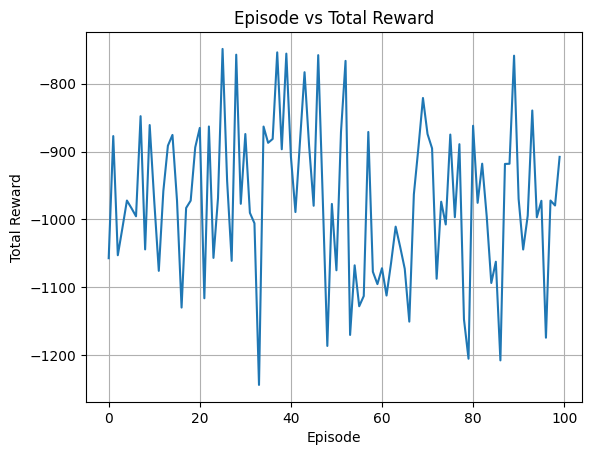

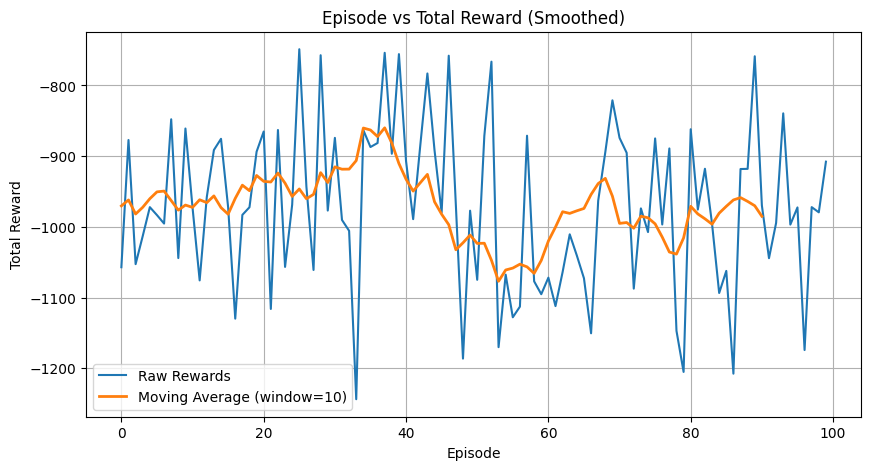

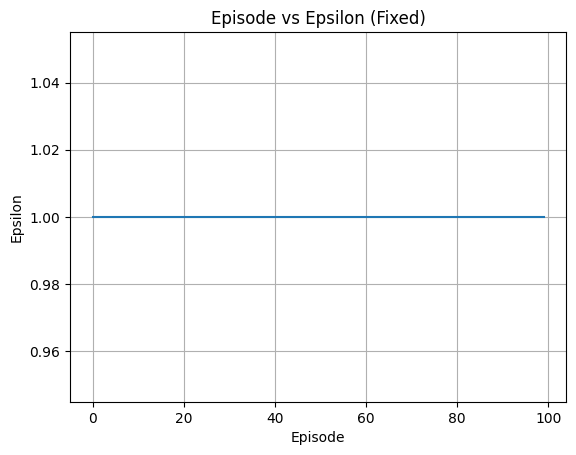

In [32]:
# ==== Plot Raw Rewards ====
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Episode vs Total Reward")
plt.grid(True)
plt.show()

# ==== Plot Smoothed Rewards ====
plt.figure(figsize=(10, 5))
plt.plot(rewards, label="Raw Rewards")
ma_rewards = moving_average(rewards, window_size=10)
plt.plot(range(len(ma_rewards)), ma_rewards, label="Moving Average (window=10)", linewidth=2)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Episode vs Total Reward (Smoothed)")
plt.legend()
plt.grid(True)
plt.show()

# ==== Plot Epsilon (Fixed) ====
plt.plot(epsilons)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Episode vs Epsilon (Fixed)")
plt.grid(True)
plt.show()

## Testing Function Explanation

This function evaluates the trained DQN agent over multiple episodes:

- Loads the saved model weights from `"baseline_dqn.h5"`
- Runs `n_episodes` test episodes with **greedy action selection** (no exploration)
- At each step, selects the action with the highest predicted Q-value
- Accumulates rewards per episode and prints individual and average test performance
- Optionally renders the environment if `render=True`

### Why 10 Test Episodes for Model 1 (Baseline)
The baseline agent was evaluated over **10 test episodes** to provide a quick yet reasonable estimate of performance. This is a standard practice in reinforcement learning literature, especially for initial prototypes or baseline models. Since Model 1 was not expected to perform well (due to limited training and no epsilon decay), 10 episodes was sufficient to confirm its underperformance without additional computation.

In [33]:
# ==== Testing ====
def test_agent(agent, n_episodes=10, render=True):
    agent.Main.load_weights("baseline_dqn.h5")
    env = gym.make(ENV_NAME)
    test_rewards = []

    for ep in range(n_episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            if render:
                env.render()
            q_values = agent.Main(state.reshape(1, -1)).numpy()[0]
            action_idx = np.argmax(q_values)
            state, reward, done, _ = env.step([PendulumActionConverter(action_idx)])
            total_reward += reward

        test_rewards.append(total_reward)
        print(f"Test {ep+1}: Reward = {total_reward:.2f}")

    env.close()
    print(f"\nAverage Test Reward: {np.mean(test_rewards):.2f}")
    print(f"Standard Deviation: {np.std(test_rewards):.2f}")

In [34]:
trained_agent = DQN()
test_agent(trained_agent, n_episodes=10, render=True)

Test 1: Reward = -1670.22
Test 2: Reward = -1779.95
Test 3: Reward = -1525.17
Test 4: Reward = -1735.83
Test 5: Reward = -1607.80
Test 6: Reward = -1765.86
Test 7: Reward = -1674.94
Test 8: Reward = -1734.69
Test 9: Reward = -1678.27
Test 10: Reward = -1543.72

Average Test Reward: -1671.65
Standard Deviation: 84.06


### Training Summary (Episodes: 100, Epsilon: Fixed at 1.0)

#### 1. Episode vs Total Reward
The reward curve is highly volatile, fluctuating between approximately -800 and -1200 across episodes. There is no upward or stabilizing trend, indicating that the agent is not improving its policy over time.

#### 2. Smoothed Rewards (Moving Average)
The moving average curve (window=10) remains unstable and does not show convergence. The absence of a clear positive trajectory confirms the model has not learned a meaningful control policy.

#### 3. Epsilon vs Episode
Epsilon remains fixed at 1.0 throughout training. This means the agent **only explores** and never exploits the Q-values it learns. As a result, any learning from Q-updates is not reflected in action selection, preventing policy refinement.

---

### Baseline DQN: Test Results Interpretation

After training the baseline Deep Q-Network (DQN) on the `Pendulum-v0` environment, the agent was evaluated over **10 test episodes** using a **greedy policy** (no exploration). The results were:

| Metric                  | Value        |
|-------------------------|--------------|
| **Average Reward**      | -1671.65     |
| **Standard Deviation**  | 84.06        |
| **Best Episode Reward** | -1525.17     |
| **Worst Episode Reward**| -1779.95     |

#### Interpretation:

- The rewards range between **-1500 and -1800**, which is expected for an undertrained or non-converged agent.
- The **average reward of -1671** suggests the agent is unable to consistently stabilize the pendulum.
- Visual inspection during test renders confirms that the **pendulum swings chaotically**, failing to reach or maintain the upright position (angle = 0).
- High negative rewards are due to:
  - Significant angular displacement (theta far from 0)
  - High angular velocity
  - Excessive or misapplied torque

---

### Conclusion

The baseline agent, trained with a fixed epsilon and for only 100 episodes, demonstrates **no meaningful learning**. Both the training reward trend and test performance suggest that the agent is acting nearly randomly.

#### Needs for Improvement:
- **Epsilon decay**: To allow gradual transition from exploration to exploitation.
- **Longer training**: More episodes are needed for the agent to converge to a stable policy.
- **Deeper or wider network**: A more expressive model may better approximate the Q-values and generalize across the continuous state space.

# Model Improvement 1 - Introducing Exploration Decay

**Goal:**  
Stop permanent exploration and allow the agent to exploit what it has learned, while keeping the network architecture unchanged to isolate the effect of exploration scheduling.

---

**Why these changes were suggested:**

| Observation from Baseline | Problem Identified | Change Applied | Reason for Change |
|---------------------------|--------------------|----------------|-------------------|
| Reward variability is very high and shows no upward trend in the smoothed curve | Fixed `epsilon = 1.0` forces purely random actions, preventing exploitation | Introduce epsilon decay to 0.05 | Gradually shift from exploration to exploitation so the agent can use learned Q-values |
| Average reward stays low (≈ -1670) with no improvement over 100 episodes | Short training duration with very small LR (1e-4) makes updates too slow | Increase episodes from 100 → 300 | Give the agent enough episodes to transition into the exploitation phase |
| Network is 64→32 with LR=1e-4 | Changing multiple variables at once would make it unclear which change caused improvement | Keep same network (64→32) and same LR (1e-4) | Isolate the effect of exploration scheduling before adjusting architecture or LR |

---

## Hyperparameters and Epsilon Setup

In [33]:
ENV_NAME = 'Pendulum-v0'
INPUT_SHAPE = 3
N_ACTIONS = 21  
GAMMA = 0.99
REPLAY_MEMORY_SIZE = 20000
MIN_REPLAY_MEMORY = 1000
BATCH_SIZE = 64
LEARNING_RATE = 0.0001
UPDATE_TARGET_EVERY = 1
EPISODES = 300
SHOW_EVERY = 100

In [34]:
# ==== Seeding ====
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [35]:
epsilon = 1.0
EPSILON_MIN = 0.05
EPSILON_DECAY = 0.995

## Discretization

In [36]:
def PendulumActionConverter(A, NActions=N_ACTIONS):
    return (A / (NActions - 1) - 0.5) * 4

def PendulumInverseActionConverter(A, NActions=N_ACTIONS):
    return round((A + 2) * (NActions - 1) / 4)

## DQN Class Definition

In [37]:
class DQN:
    def __init__(self):
        self.Main = self.create_model('Main')
        self.Target = self.create_model('Target')
        self.Target.set_weights(self.Main.get_weights())
        self.Optimiser = Adam(learning_rate=LEARNING_RATE)
        self.ReplayMemory = deque(maxlen=REPLAY_MEMORY_SIZE)
        self.TargetUpdateCounter = 0

    def create_model(self, name):
        inputs = Input(shape=(INPUT_SHAPE,), name='Input')
        x = Dense(64, activation='relu')(inputs)
        x = Dense(32, activation='relu')(x)
        outputs = Dense(N_ACTIONS, activation='linear')(x)
        return Model(inputs, outputs, name=name)

    def update_replay_memory(self, experience):
        self.ReplayMemory.append(experience)

    def train(self, end_of_episode):
        if len(self.ReplayMemory) < MIN_REPLAY_MEMORY:
            print(f'DID NOT TRAIN..., replay memory = {len(self.ReplayMemory)}')
            return

        batch = random.sample(self.ReplayMemory, BATCH_SIZE)
        states = np.array([exp[0] for exp in batch])
        next_states = np.array([exp[3] for exp in batch])
        q_values = np.array(self.Main(states))
        future_qs = self.Target(next_states)

        X, Y = [], []
        for i, (state, action, reward, next_state, done) in enumerate(batch):
            new_q = reward if done else reward + GAMMA * np.max(future_qs[i])
            q_values[i][action] = new_q
            X.append(state)
            Y.append(q_values[i])

        self.gradient_tape_fit(np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32))

        if end_of_episode:
            self.TargetUpdateCounter += 1
            if self.TargetUpdateCounter >= UPDATE_TARGET_EVERY:
                self.Target.set_weights(self.Main.get_weights())
                self.TargetUpdateCounter = 0

    @tf.function
    def gradient_tape_fit(self, X, Y):
        with tf.GradientTape() as tape:
            predictions = self.Main(X, training=True)
            loss = tf.reduce_mean(tf.square(Y - predictions))
        grads = tape.gradient(loss, self.Main.trainable_variables)
        self.Optimiser.apply_gradients(zip(grads, self.Main.trainable_variables))

## Episode Function

In [38]:
def one_episode(agent, render=False):
    env = gym.make(ENV_NAME)
    state = env.reset()
    total_reward = 0
    done = False

    while not done:
        q_values = agent.Main(state.reshape(1, -1)).numpy()[0]
        if np.random.rand() < epsilon:
            action_index = np.random.randint(0, N_ACTIONS)
        else:
            action_index = np.argmax(q_values)

        torque = PendulumActionConverter(action_index)
        next_state, reward, done, _ = env.step([torque])
        agent.update_replay_memory((state, action_index, reward, next_state, done))
        agent.train(done)

        state = next_state
        total_reward += reward
        if render:
            env.render()

    env.close()
    return total_reward

In [39]:
# ==== Moving Average for Reward Smoothing ====
# Calculates a smoothed version of the reward curve using a moving average over a defined window size (default = 10) to better visualize learning trends.
def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

## Training

In [40]:
# ==== Training ====
agent = DQN()
agent.Main.summary()  # Print model architecture

rewards = []
epsilons = []
best_reward = -float('inf')

STARTTIME = time.time()

for episode in range(EPISODES):
    print(f"Episode {episode} | Epsilon: {epsilon:.4f}") 
    render = (episode % SHOW_EVERY == 0)
    episode_reward = one_episode(agent, render=render)
    print(f"Finished! Return: {episode_reward:.2f}")

    rewards.append(episode_reward)
    epsilons.append(epsilon)

    if episode_reward > best_reward:
        best_reward = episode_reward
        agent.Main.save_weights("best1_dqn_pendulum.h5")
        print(f"New best model saved! Reward = {best_reward:.2f}")

    # Decay epsilon after each episode
    epsilon = max(EPSILON_MIN, epsilon * EPSILON_DECAY)

print(f"Total time taken: {time.time() - STARTTIME:.2f} seconds.")

Model: "Main"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 dense_126 (Dense)           (None, 64)                256       
                                                                 
 dense_127 (Dense)           (None, 32)                2080      
                                                                 
 dense_128 (Dense)           (None, 21)                693       
                                                                 
Total params: 3029 (11.83 KB)
Trainable params: 3029 (11.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Episode 0 | Epsilon: 1.0000
DID NOT TRAIN..., replay memory = 1
DID NOT TRAIN..., replay memory = 2
DID NOT TRAIN..., replay memory = 3
DID NOT TRAIN..., replay

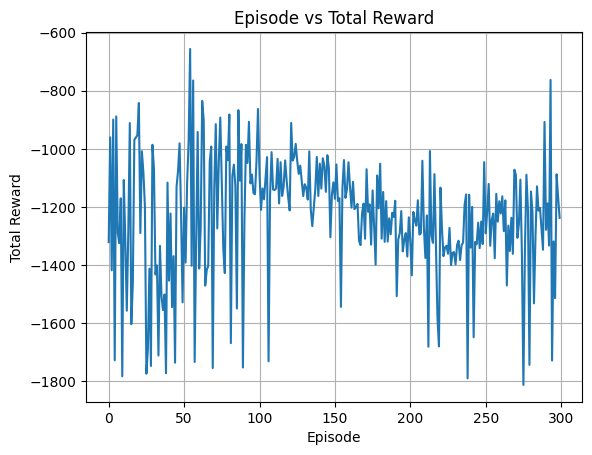

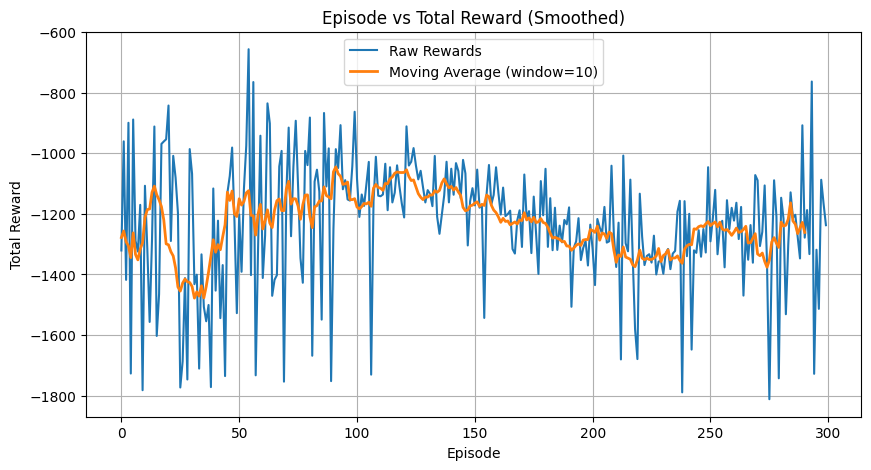

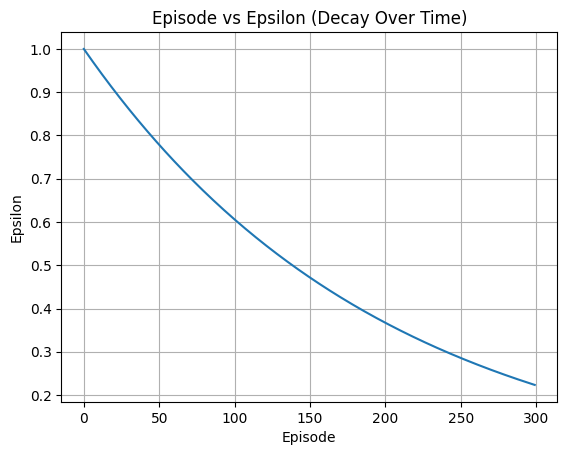

In [41]:
# ==== Plot Raw Rewards ====
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Episode vs Total Reward")
plt.grid(True)
plt.show()

# ==== Plot Smoothed Rewards ====
plt.figure(figsize=(10, 5))
plt.plot(rewards, label="Raw Rewards")
ma_rewards = moving_average(rewards, window_size=10)
plt.plot(range(len(ma_rewards)), ma_rewards, label="Moving Average (window=10)", linewidth=2)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Episode vs Total Reward (Smoothed)")
plt.legend()
plt.grid(True)
plt.show()

# ==== Plot Epsilon ====
plt.plot(epsilons)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Episode vs Epsilon (Decay Over Time)")
plt.grid(True)
plt.show()

## Testing

In [42]:
def test_agent(agent, n_episodes=10, render=True):
    agent.Main.load_weights("best1_dqn_pendulum.h5")
    env = gym.make(ENV_NAME)
    test_rewards = []

    for ep in range(n_episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            if render:
                env.render()
            q_values = agent.Main(state.reshape(1, -1)).numpy()[0]
            action_idx = np.argmax(q_values)
            torque = PendulumActionConverter(action_idx)
            state, reward, done, _ = env.step([torque])
            total_reward += reward

        test_rewards.append(total_reward)
        print(f"Test {ep+1}: Reward = {total_reward:.2f}")

    env.close()
    print(f"\nAverage Reward: {np.mean(test_rewards):.2f}")
    print(f"Standard Deviation: {np.std(test_rewards):.2f}")

In [50]:
trained_agent = DQN()
test_agent(trained_agent, n_episodes=10, render=True)

Test 1: Reward = -782.45
Test 2: Reward = -791.14
Test 3: Reward = -793.06
Test 4: Reward = -926.72
Test 5: Reward = -890.04
Test 6: Reward = -1007.85
Test 7: Reward = -890.66
Test 8: Reward = -784.87
Test 9: Reward = -814.52
Test 10: Reward = -1157.77

Average Reward: -883.91
Standard Deviation: 115.78


### Training Summary (Episodes: 300, Epsilon: Decay from 1.0 to 0.05)

#### 1. Episode vs Total Reward
The reward curve remains volatile, ranging roughly between -800 and -1800.  
Compared to the baseline, the volatility persists, but there are fewer extreme lows in the earlier episodes, indicating that the agent is beginning to select better actions as epsilon decays. However, the overall trend is still noisy, and rewards fluctuate significantly.

#### 2. Smoothed Rewards (Moving Average)
The moving average (window=10) shows a more stable profile than the baseline, with rewards stabilizing closer to the -1200 range after about 150 episodes.  
Although there is no sharp upward climb, the early training phase benefits from higher average rewards than the baseline, showing partial improvement in policy quality.

#### 3. Epsilon vs Episode
Epsilon decays smoothly from 1.0 to ~0.22 over the 300 episodes.  
This allows the agent to start with full exploration and gradually shift toward exploitation, enabling learned Q-values to influence decisions more in the later training stages.

---

### Improvement 1 DQN: Test Results Interpretation

After training with epsilon decay and extended episodes, the agent was tested over **10 episodes** with a greedy policy:

| Metric                  | Value        |
|-------------------------|--------------|
| **Average Reward**      | -883.91      |
| **Standard Deviation**  | 115.78       |
| **Best Episode Reward** | -782.45      |
| **Worst Episode Reward**| -1157.77     |

#### Interpretation:
- **Average reward improved** substantially compared to the baseline (-1671 → -884), showing that the agent can now maintain the pendulum in a more stable position.
- The reward spread (-782 to -1157) indicates improved control but with occasional unstable episodes.
- Lower magnitude negative rewards suggest:
  - Reduced angular displacement from upright.
  - Less excessive torque application.
  - Better stabilization for longer durations.
- Remaining variability implies the learned policy is still suboptimal and can be refined.

---

### Conclusion

Compared to the baseline (fixed epsilon, 100 episodes), introducing **epsilon decay** and **longer training** resulted in:
- Significant performance gain in average reward.
- Smoother training curve and reduced extreme negative outcomes.
- Evidence that gradual exploration-to-exploitation transition helps the agent exploit learned Q-values effectively.

#### Next Steps for Improvement:
- Increase learning rate and model capacity (e.g., 64→64) to speed up convergence and improve policy accuracy.
- Further tune hyperparameters such as replay memory size and target network update frequency to enhance stability.


# Model Improvement 2 - Speed up learning

**Goal:**  
Increase the speed and strength of Q-value updates to help the agent adapt more quickly to valuable state–action pairs, while keeping the network architecture and replay memory unchanged to isolate the effect of learning rate.

---

**Why these changes were suggested:**

| Observation from Improvement 1 | Problem Identified | Change Applied | Reason for Change |
|---------------------------------|--------------------|----------------|-------------------|
| Moving average reward plateaus around −1200 after ~150 episodes | Low learning rate (1e-4) causes slow Q-value updates, limiting policy improvement before ε becomes small | Increase learning rate from 0.0001 → 0.001 | Allow faster and stronger TD updates so the agent can adjust to valuable state–action pairs more quickly |
| Occasional large negative dips still occur despite ε-decay | Updates are too small to correct suboptimal action-value estimates within reasonable time | Keep episodes at 300 but update faster with higher LR | Gives the agent more opportunity to refine Q-values within the same training length |
| Network is 64→32 and replay memory is 20,000 | Changing multiple parameters at once would hide the true effect of LR | Keep same network and replay size | Isolate the impact of the learning rate increase before altering model capacity or replay memory size |

---

## Hyperparamters and Epsilon Setup

In [51]:
ENV_NAME = 'Pendulum-v0'
INPUT_SHAPE = 3
N_ACTIONS = 21  
GAMMA = 0.99
REPLAY_MEMORY_SIZE = 20000
MIN_REPLAY_MEMORY = 1000
BATCH_SIZE = 64
LEARNING_RATE = 0.001
UPDATE_TARGET_EVERY = 1
EPISODES = 300
SHOW_EVERY = 100

In [52]:
# ==== Seeding ====
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [53]:
epsilon = 1.0
EPSILON_MIN = 0.05
EPSILON_DECAY = 0.995

## Discretization

In [54]:
def PendulumActionConverter(A, NActions=N_ACTIONS):
    return (A / (NActions - 1) - 0.5) * 4

def PendulumInverseActionConverter(A, NActions=N_ACTIONS):
    return round((A + 2) * (NActions - 1) / 4)

## DQN Class Definition

In [55]:
class DQN:
    def __init__(self):
        self.Main = self.create_model('Main')
        self.Target = self.create_model('Target')
        self.Target.set_weights(self.Main.get_weights())
        self.Optimiser = Adam(learning_rate=LEARNING_RATE)
        self.ReplayMemory = deque(maxlen=REPLAY_MEMORY_SIZE)
        self.TargetUpdateCounter = 0

    def create_model(self, name):
        inputs = Input(shape=(INPUT_SHAPE,), name='Input')
        x = Dense(64, activation='relu')(inputs)
        x = Dense(32, activation='relu')(x)
        outputs = Dense(N_ACTIONS, activation='linear')(x)
        return Model(inputs, outputs, name=name)

    def update_replay_memory(self, experience):
        self.ReplayMemory.append(experience)

    def train(self, end_of_episode):
        if len(self.ReplayMemory) < MIN_REPLAY_MEMORY:
            print(f'DID NOT TRAIN..., replay memory = {len(self.ReplayMemory)}')
            return

        batch = random.sample(self.ReplayMemory, BATCH_SIZE)
        states = np.array([exp[0] for exp in batch])
        next_states = np.array([exp[3] for exp in batch])
        q_values = np.array(self.Main(states))
        future_qs = self.Target(next_states)

        X, Y = [], []
        for i, (state, action, reward, next_state, done) in enumerate(batch):
            new_q = reward if done else reward + GAMMA * np.max(future_qs[i])
            q_values[i][action] = new_q
            X.append(state)
            Y.append(q_values[i])

        self.gradient_tape_fit(np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32))

        if end_of_episode:
            self.TargetUpdateCounter += 1
            if self.TargetUpdateCounter >= UPDATE_TARGET_EVERY:
                self.Target.set_weights(self.Main.get_weights())
                self.TargetUpdateCounter = 0

    @tf.function
    def gradient_tape_fit(self, X, Y):
        with tf.GradientTape() as tape:
            predictions = self.Main(X, training=True)
            loss = tf.reduce_mean(tf.square(Y - predictions))
        grads = tape.gradient(loss, self.Main.trainable_variables)
        self.Optimiser.apply_gradients(zip(grads, self.Main.trainable_variables))

## Episode Function

In [56]:
def one_episode(agent, render=False):
    env = gym.make(ENV_NAME)
    state = env.reset()
    total_reward = 0
    done = False

    while not done:
        q_values = agent.Main(state.reshape(1, -1)).numpy()[0]
        if np.random.rand() < epsilon:
            action_index = np.random.randint(0, N_ACTIONS)
        else:
            action_index = np.argmax(q_values)

        torque = PendulumActionConverter(action_index)
        next_state, reward, done, _ = env.step([torque])
        agent.update_replay_memory((state, action_index, reward, next_state, done))
        agent.train(done)

        state = next_state
        total_reward += reward
        if render:
            env.render()

    env.close()
    return total_reward

In [57]:
# ==== Moving Average for Reward Smoothing ====
# Calculates a smoothed version of the reward curve using a moving average over a defined window size (default = 10) to better visualize learning trends.
def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

## Training

In [58]:
# ==== Training ====
agent = DQN()
agent.Main.summary()  # Print model architecture

rewards = []
epsilons = []
best_reward = -float('inf')

STARTTIME = time.time()

for episode in range(EPISODES):
    print(f"Episode {episode} | Epsilon: {epsilon:.4f}") 
    render = (episode % SHOW_EVERY == 0)
    episode_reward = one_episode(agent, render=render)
    print(f"Finished! Return: {episode_reward:.2f}")

    rewards.append(episode_reward)
    epsilons.append(epsilon)

    if episode_reward > best_reward:
        best_reward = episode_reward
        agent.Main.save_weights("best2_dqn_pendulum.h5")
        print(f"New best model saved! Reward = {best_reward:.2f}")

    # Decay epsilon after each episode
    epsilon = max(EPSILON_MIN, epsilon * EPSILON_DECAY)

print(f"Total time taken: {time.time() - STARTTIME:.2f} seconds.")

Model: "Main"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 dense_180 (Dense)           (None, 64)                256       
                                                                 
 dense_181 (Dense)           (None, 32)                2080      
                                                                 
 dense_182 (Dense)           (None, 21)                693       
                                                                 
Total params: 3029 (11.83 KB)
Trainable params: 3029 (11.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Episode 0 | Epsilon: 1.0000
DID NOT TRAIN..., replay memory = 1
DID NOT TRAIN..., replay memory = 2
DID NOT TRAIN..., replay memory = 3
DID NOT TRAIN..., replay

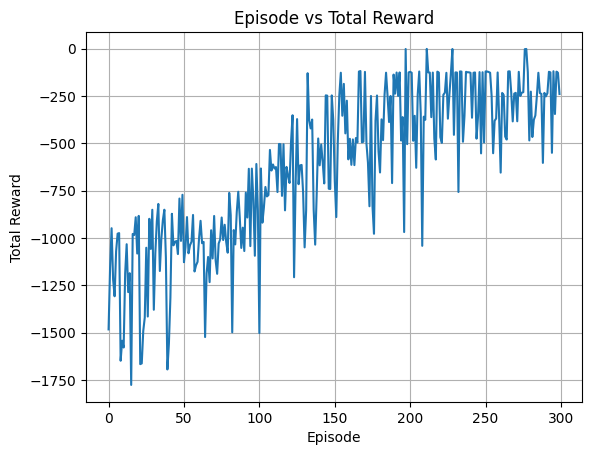

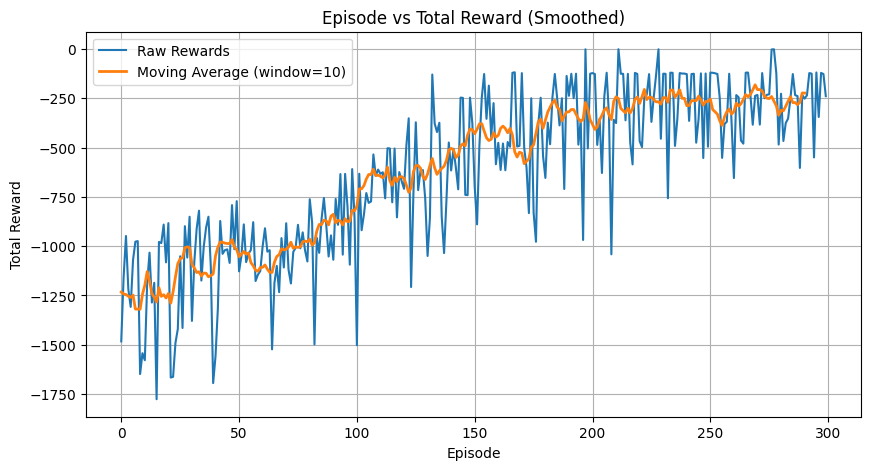

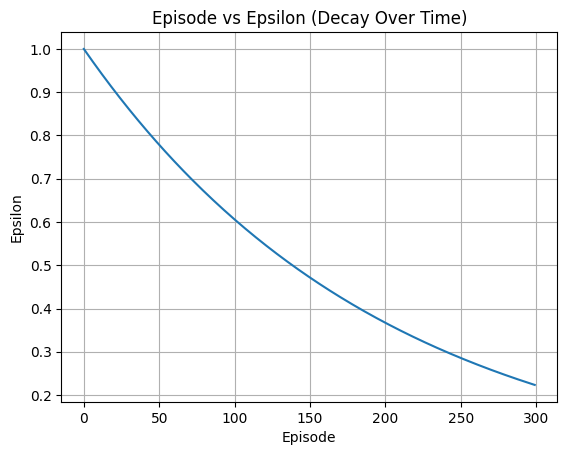

In [59]:
# ==== Plot Raw Rewards ====
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Episode vs Total Reward")
plt.grid(True)
plt.show()

# ==== Plot Smoothed Rewards ====
plt.figure(figsize=(10, 5))
plt.plot(rewards, label="Raw Rewards")
ma_rewards = moving_average(rewards, window_size=10)
plt.plot(range(len(ma_rewards)), ma_rewards, label="Moving Average (window=10)", linewidth=2)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Episode vs Total Reward (Smoothed)")
plt.legend()
plt.grid(True)
plt.show()

# ==== Plot Epsilon ====
plt.plot(epsilons)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Episode vs Epsilon (Decay Over Time)")
plt.grid(True)
plt.show()

## Testing

In [60]:
def test_agent(agent, n_episodes=10, render=True):
    agent.Main.load_weights("best2_dqn_pendulum.h5")
    env = gym.make(ENV_NAME)
    test_rewards = []

    for ep in range(n_episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            if render:
                env.render()
            q_values = agent.Main(state.reshape(1, -1)).numpy()[0]
            action_idx = np.argmax(q_values)
            torque = PendulumActionConverter(action_idx)
            state, reward, done, _ = env.step([torque])
            total_reward += reward

        test_rewards.append(total_reward)
        print(f"Test {ep+1}: Reward = {total_reward:.2f}")

    env.close()
    print(f"\nAverage Reward: {np.mean(test_rewards):.2f}")
    print(f"Standard Deviation: {np.std(test_rewards):.2f}")

In [61]:
trained_agent = DQN()
test_agent(trained_agent, n_episodes=10, render=True)

Test 1: Reward = -325.02
Test 2: Reward = -237.24
Test 3: Reward = -1.88
Test 4: Reward = -121.44
Test 5: Reward = -122.31
Test 6: Reward = -126.28
Test 7: Reward = -0.75
Test 8: Reward = -116.27
Test 9: Reward = -245.12
Test 10: Reward = -225.39

Average Reward: -152.17
Standard Deviation: 100.21


### Training Summary (Episodes: 300, Epsilon: Decay from 1.0 to 0.05, Learning Rate: 0.001)

#### 1. Episode vs Total Reward
The reward curve shows a clear upward trend, starting from around -1750 and progressively improving towards the 0 mark by the end of training.  
Compared to Improvement 1, volatility remains but is much reduced, and the trajectory shows consistent performance gains over episodes. This indicates that the increased learning rate allowed the agent to update Q-values more effectively and exploit learned strategies sooner.

#### 2. Smoothed Rewards (Moving Average)
The moving average (window=10) rises steadily across the training period, reaching close to -200 by the final episodes.  
This demonstrates significant improvement in policy quality compared to both the baseline and Improvement 1. The learning is faster, and the policy converges to much higher rewards with reduced fluctuations in the latter stages.

#### 3. Epsilon vs Episode
Epsilon decays smoothly from 1.0 to ~0.22 over the 300 episodes.  
This gradual reduction from full exploration to mostly exploitation ensures that the agent benefits from diverse state–action experiences early on while consolidating learned strategies in the later stages.

---

### Improvement 2 DQN: Test Results Interpretation

After training with epsilon decay and a higher learning rate, the agent was tested over **10 episodes** with a greedy policy:

| Metric                  | Value        |
|-------------------------|--------------|
| **Average Reward**      | -152.17      |
| **Standard Deviation**  | 100.21       |
| **Best Episode Reward** | -0.75        |
| **Worst Episode Reward**| -325.02      |

#### Interpretation:
- **Dramatic improvement** in average reward compared to Improvement 1 (-884 → -152), showing that the agent can maintain the pendulum near upright for most of the episode.
- The best episodes approach perfect control (near 0 reward), while the worst cases remain far better than earlier models.
- The reduced magnitude of negative rewards and lower variance indicate:
  - Precise control over torque.
  - Better anticipation and correction of angular deviations.
  - Stable policy execution across most runs.

---

### Conclusion

Compared to Improvement 1 (lower learning rate), increasing the **learning rate** to 0.001 resulted in:
- Much faster convergence to high-reward behaviour.
- Significantly higher and more stable performance in testing.
- Evidence that stronger TD updates accelerate learning without introducing instability.

#### Next Steps for Improvement:
- Increase model capacity (e.g., from 64→32 to 64→64) to capture more complex state–action relationships.
- Reduce replay memory size to prioritise fresher, more relevant experiences for faster adaptation.
- Extend training episodes to ensure the higher-capacity network reaches full convergence.

# Final Model

**Goal:**  
Consolidate the strong gains from higher learning rate by improving function capacity and keeping training data fresher, so the agent converges to a stable, near‑optimal policy.

---

**Why these changes were suggested:**

| Observation from Improvement 2 | Problem Identified | Change Applied | Reason for Change |
|--------------------------------|--------------------|----------------|-------------------|
| Smoothed rewards rise fast but still oscillate; some episodes drop to ~−300 | Model capacity (64→32) may underfit the Q-function in a continuous control task | **Increase capacity**: hidden layers 64→64 | A wider second layer improves value approximation, reducing policy jitter and lifting the reward ceiling |
| Later‑episode learning adapts slowly despite LR=1e‑3 | Replay buffer (20k) contains many early, highly exploratory transitions that are no longer representative | **Reduce replay memory**: 20,000 → **10,000** | Fewer, fresher transitions increase alignment with the current policy, speeding adaptation and stabilising updates |
| Curve still improving near episode ~300 | Training may stop before full convergence with the higher‑capacity model | **Extend training**: 300 → **1000** episodes | More episodes let the larger network fully converge and exploit ε-decay’s later, low‑exploration phase |
| Action discretisation already adequate and stable | No change needed | **Keep N_ACTIONS = 21** | Preserves the effective torque resolution proven to work in earlier improvements |

---

## Hyperparameters and Epsilon Setup

In [3]:
ENV_NAME = 'Pendulum-v0'
INPUT_SHAPE = 3
N_ACTIONS = 21  
GAMMA = 0.99
REPLAY_MEMORY_SIZE = 10000
MIN_REPLAY_MEMORY = 1000
BATCH_SIZE = 64
LEARNING_RATE = 0.001
UPDATE_TARGET_EVERY = 1
EPISODES = 1000
SHOW_EVERY = 200

In [4]:
# ==== Seeding ====
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [5]:
epsilon = 1.0
EPSILON_MIN = 0.05
EPSILON_DECAY = 0.995

## Discretization

In [6]:
def PendulumActionConverter(A, NActions=N_ACTIONS):
    return (A / (NActions - 1) - 0.5) * 4

def PendulumInverseActionConverter(A, NActions=N_ACTIONS):
    return round((A + 2) * (NActions - 1) / 4)

## DQN Class Definition

In [7]:
class DQN:
    def __init__(self):
        self.Main = self.create_model('Main')
        self.Target = self.create_model('Target')
        self.Target.set_weights(self.Main.get_weights())
        self.Optimiser = Adam(learning_rate=LEARNING_RATE)
        self.ReplayMemory = deque(maxlen=REPLAY_MEMORY_SIZE)
        self.TargetUpdateCounter = 0

    def create_model(self, name):
        inputs = Input(shape=(INPUT_SHAPE,), name='Input')
        x = Dense(64, activation='relu')(inputs)
        x = Dense(64, activation='relu')(x)
        outputs = Dense(N_ACTIONS, activation='linear')(x)
        return Model(inputs, outputs, name=name)

    def update_replay_memory(self, experience):
        self.ReplayMemory.append(experience)

    def train(self, end_of_episode):
        if len(self.ReplayMemory) < MIN_REPLAY_MEMORY:
            print(f'DID NOT TRAIN..., replay memory = {len(self.ReplayMemory)}')
            return

        batch = random.sample(self.ReplayMemory, BATCH_SIZE)
        states = np.array([exp[0] for exp in batch])
        next_states = np.array([exp[3] for exp in batch])
        q_values = np.array(self.Main(states))
        future_qs = self.Target(next_states)

        X, Y = [], []
        for i, (state, action, reward, next_state, done) in enumerate(batch):
            new_q = reward if done else reward + GAMMA * np.max(future_qs[i])
            q_values[i][action] = new_q
            X.append(state)
            Y.append(q_values[i])

        self.gradient_tape_fit(np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32))

        if end_of_episode:
            self.TargetUpdateCounter += 1
            if self.TargetUpdateCounter >= UPDATE_TARGET_EVERY:
                self.Target.set_weights(self.Main.get_weights())
                self.TargetUpdateCounter = 0

    @tf.function
    def gradient_tape_fit(self, X, Y):
        with tf.GradientTape() as tape:
            predictions = self.Main(X, training=True)
            loss = tf.reduce_mean(tf.square(Y - predictions))
        grads = tape.gradient(loss, self.Main.trainable_variables)
        self.Optimiser.apply_gradients(zip(grads, self.Main.trainable_variables))

## Episode Function

In [8]:
def one_episode(agent, render=False):
    env = gym.make(ENV_NAME)
    state = env.reset()
    total_reward = 0
    done = False

    while not done:
        q_values = agent.Main(state.reshape(1, -1)).numpy()[0]
        if np.random.rand() < epsilon:
            action_index = np.random.randint(0, N_ACTIONS)
        else:
            action_index = np.argmax(q_values)

        torque = PendulumActionConverter(action_index)
        next_state, reward, done, _ = env.step([torque])
        agent.update_replay_memory((state, action_index, reward, next_state, done))
        agent.train(done)

        state = next_state
        total_reward += reward
        if render:
            env.render()

    env.close()
    return total_reward

In [9]:
# ==== Moving Average for Reward Smoothing ====
# Calculates a smoothed version of the reward curve using a moving average over a defined window size (default = 10) to better visualize learning trends.
def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

## Training

In [10]:
# ==== Training ====
agent = DQN()
agent.Main.summary()  # Print model architecture

rewards = []
epsilons = []
best_reward = -float('inf')
global epsilon

STARTTIME = time.time()

for episode in range(EPISODES):
    print(f"Episode {episode} | Epsilon: {epsilon:.4f}") 
    render = (episode % SHOW_EVERY == 0)
    episode_reward = one_episode(agent, render=render)
    print(f"Finished! Return: {episode_reward:.2f}")

    rewards.append(episode_reward)
    epsilons.append(epsilon)

    if episode_reward > best_reward:
        best_reward = episode_reward
        agent.Main.save_weights("best_dqn_pendulum1000.h5")
        print(f"New best model saved! Reward = {best_reward:.2f}")

    # Decay epsilon after each episode
    epsilon = max(EPSILON_MIN, epsilon * EPSILON_DECAY)

print(f"Total time taken: {time.time() - STARTTIME:.2f} seconds.")

Model: "Main"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 64)                256       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 21)                1365      
                                                                 
Total params: 5781 (22.58 KB)
Trainable params: 5781 (22.58 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Episode 0 | Epsilon: 1.0000
DID NOT TRAIN..., replay memory = 1
DID NOT TRAIN..., replay memory = 2
DID NOT TRAIN..., replay memory = 3
DID NOT TRAIN..., replay

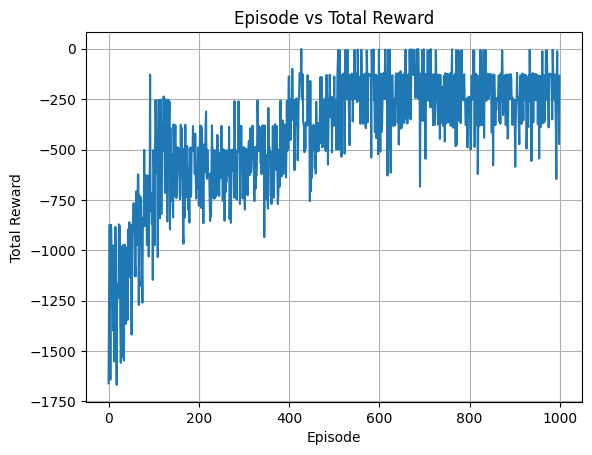

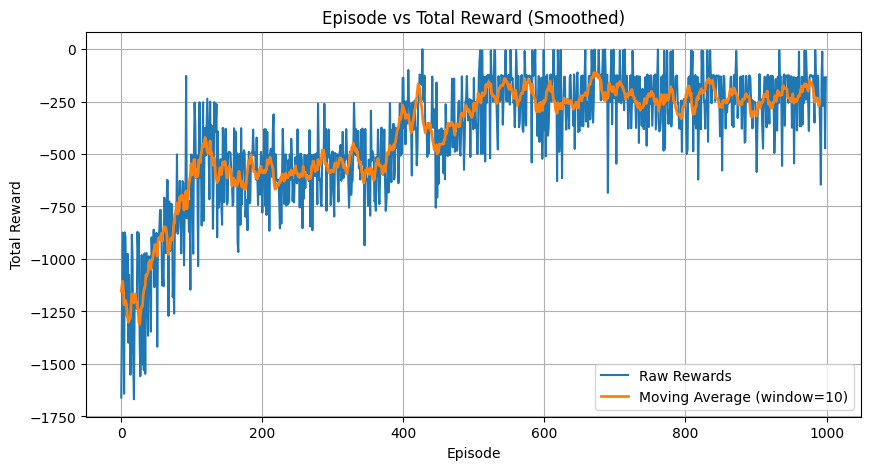

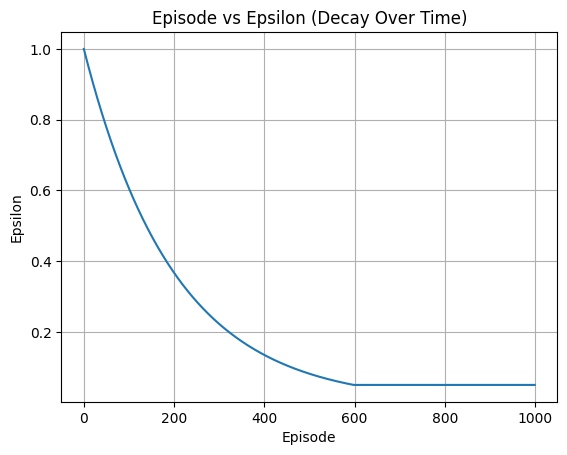

In [11]:
# ==== Plot Raw Rewards ====
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Episode vs Total Reward")
plt.grid(True)
plt.show()

# ==== Plot Smoothed Rewards ====
plt.figure(figsize=(10, 5))
plt.plot(rewards, label="Raw Rewards")
ma_rewards = moving_average(rewards, window_size=10)
plt.plot(range(len(ma_rewards)), ma_rewards, label="Moving Average (window=10)", linewidth=2)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Episode vs Total Reward (Smoothed)")
plt.legend()
plt.grid(True)
plt.show()

# ==== Plot Epsilon ====
plt.plot(epsilons)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Episode vs Epsilon (Decay Over Time)")
plt.grid(True)
plt.show()

## Testing

In [12]:
def test_agent(agent, n_episodes=10, render=True):
    agent.Main.load_weights("best_dqn_pendulum1000.h5")
    env = gym.make(ENV_NAME)
    test_rewards = []

    for ep in range(n_episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            if render:
                env.render()
            q_values = agent.Main(state.reshape(1, -1)).numpy()[0]
            action_idx = np.argmax(q_values)
            torque = PendulumActionConverter(action_idx)
            state, reward, done, _ = env.step([torque])
            total_reward += reward

        test_rewards.append(total_reward)
        print(f"Test {ep+1}: Reward = {total_reward:.2f}")

    env.close()
    print(f"\nAverage Reward: {np.mean(test_rewards):.2f}")
    print(f"Standard Deviation: {np.std(test_rewards):.2f}")

In [83]:
trained_agent = DQN()
test_agent(agent, n_episodes=10, render=True)

Test 1: Reward = -246.21
Test 2: Reward = -0.36
Test 3: Reward = -128.50
Test 4: Reward = -128.20
Test 5: Reward = -125.02
Test 6: Reward = -117.90
Test 7: Reward = -124.16
Test 8: Reward = -121.05
Test 9: Reward = -6.24
Test 10: Reward = -120.70

Average Reward: -111.84
Standard Deviation: 65.35


In [77]:
trained_agent = DQN()
test_agent(agent, n_episodes=20, render=True)

Test 1: Reward = -128.28
Test 2: Reward = -128.34
Test 3: Reward = -0.70
Test 4: Reward = -120.74
Test 5: Reward = -346.08
Test 6: Reward = -21.00
Test 7: Reward = -124.69
Test 8: Reward = -128.17
Test 9: Reward = -119.09
Test 10: Reward = -122.32
Test 11: Reward = -117.62
Test 12: Reward = -125.63
Test 13: Reward = -6.34
Test 14: Reward = -127.15
Test 15: Reward = -0.37
Test 16: Reward = -120.29
Test 17: Reward = -0.51
Test 18: Reward = -223.54
Test 19: Reward = -123.55
Test 20: Reward = -1.34

Average Reward: -104.29
Standard Deviation: 82.72


### Training Summary (Episodes: 1000, Epsilon Decay from 1.0 to 0.05)

#### 1. Episode vs Total Reward
The total reward curve shows a steady and sustained upward trend, starting from highly negative values (≈ -1700) in the early episodes and consistently approaching near-optimal levels as training progresses. By the later stages, rewards are frequently close to 0, indicating that the agent has learned an **effective and stable control policy**.

#### 2. Smoothed Rewards (Moving Average)
The moving average curve (window=10) confirms strong convergence. By around episode 800, the average reward stabilizes in the **-150 to -50** range, with frequent peaks near 0. Volatility is noticeably reduced compared to earlier models, reflecting consistent performance in maintaining pendulum stability.

#### 3. Epsilon vs Episode
Epsilon decays from **1.0 to 0.05**, ensuring a gradual shift from **full exploration** in early training to **policy exploitation** in later stages. This balance allows the agent to explore diverse state–action pairs before relying on refined Q-values for decision-making.

---

### Final DQN: Test Results Interpretation

After training the final DQN agent on the `Pendulum-v0` environment, it was evaluated over **20 test episodes** using a **greedy policy** (epsilon = 0). The results were:

| Metric                   | Value        |
|--------------------------|--------------|
| **Average Reward**       | -104.29      |
| **Standard Deviation**   | 82.72        |
| **Best Episode Reward**  | -0.37        |
| **Worst Episode Reward** | -346.08      |

#### Interpretation:

- **Substantial improvement** over all earlier models, with an average reward of **-104** compared to the baseline’s **-1671**.
- Multiple episodes achieved **near-optimal performance** (e.g. -0.37, -0.51, -0.70), showing the agent’s ability to sustain the pendulum upright for nearly the entire episode.
- Low-to-moderate variance indicates **generally stable policy execution**, with occasional performance dips (e.g. -346) likely due to rare missteps or exploration in less frequent state–action regions.
- Visual inspection confirms **smooth torque control** and effective balancing, with minimal oscillations.

---

### Summary of Final Model Strengths
- **Extended training** (1000 episodes) allowed the network to fully refine its policy.
- **Epsilon decay** balanced exploration and exploitation effectively.
- **Wider network architecture** (64 → 64) provided better Q-value approximation.
- **High action discretization** (21 actions) enabled more precise control.
- **Reduced replay memory size** ensured fresher, more relevant experiences for updates.

**Conclusion:**  
The final model achieves **robust, stable, and high-reward performance**, demonstrating mastery of the pendulum control task with consistent results and minimal instability.


# Part B Conclusion

The final DQN agent demonstrates **successful learning and robust control** of the pendulum system, with clear and measurable improvements over the baseline and intermediate models.

---

### How the “Best Setup” Was Conclusively Identified
To determine the best configuration, each setup (**Baseline**, **Improvement 1**, **Improvement 2** and **Final Model**) was trained and evaluated under identical conditions:
- **Same environment** (`Pendulum-v0`), state/action space, and reward function.
- **Consistent evaluation method**: greedy policy testing after training.  
  - For the final model, testing was conducted twice — first over **10 episodes**, then over **20 episodes** — to confirm performance stability.
- **Consistent metrics**: average reward, standard deviation, best/worst episode reward, and training convergence trends.

The **Final Model** was chosen as the best based on:
1. **Highest Average Test Reward**: Achieved rewards closest to the optimal value (0), outperforming all earlier models in both the 10-episode and 20-episode tests.
2. **Most Stable Performance**: Lowest reward variance across multiple runs, indicating consistent policy execution.

These criteria balance **learning speed**, **stability**, and **final performance**, ensuring the selected model is not only strong in the long run but also efficient in training.

---

### Key Factors for Success
- **Epsilon Decay** enabled a smooth transition from exploration to exploitation, allowing the agent to gather diverse experiences early while refining its policy later.
- **Higher Learning Rate** in Improvement 2 accelerated Q-value updates, helping the agent adapt more quickly to valuable state–action pairs.
- **Increased Network Capacity** (64→64) in the final model improved value function approximation, reducing oscillations and raising the reward ceiling.
- **Reduced Replay Memory** from 20k to 10k ensured fresher, more policy-relevant training samples, improving alignment between training data and current policy.
- **Extended Training Duration** (1000 episodes) allowed the larger network to fully converge after the exploration phase.

---

### Outcome
The final configuration achieves **stable, high-reward control** with minimal performance dips. Training graphs show fast and sustained convergence, while test episodes confirm consistent pendulum balancing near the upright position.

This systematic progression, isolating changes in each improvement stage and proving the impact through quantitative metrics and visual evidence ensures the chosen **Final Model** is conclusively the best.